In [1]:
# import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler, Nystroem
import gym


In [15]:
def print_values(V,g):
    pass

def print_policy(P,g):
    pass

def epsilon_greedy(model, state, eps=0.1):
    '''
    return an actions based on the epsilon greedy concept : exploration vs exploitation
    random action if < epx else best action
    '''
    p = np.random.random()
    if p < eps:
        a = model.cart_pole.action_space.sample()
    else:
        values = model.predict_all_actions(state)
        a = np.argmax(values)
    return a



In [13]:
SMALL_ENOUGH = 1e-3
gamma = 0.99    
ALPHA = 0.1

def gather_samples(cart_pole, n_episodes = 10000):
    '''
    return a dataset to feed a model with X_train dataset 
    Not requested for RBF but it's a more generic implementation
    '''
    samples = []
    # play n episodes
    for _ in range(n_episodes):
        #set to the initial state
        s = cart_pole.reset()
        done = False
        # play one episode
        while not done:
            a = cart_pole.action_space.sample()
            sa = np.concatenate((s, [a]))
            samples.append(sa)
            
            s, r, done, info = cart_pole.step(a)
    return samples

class Model:
    '''
    implement the model of the linear regression with the phi transformation
    '''
    def __init__(self, cart_pole):
        '''
        constructor that fit the featurizer phi to data
        '''
        self.cart_pole = cart_pole
        samples = gather_samples(cart_pole)
        self.featurizer = RBFSampler()
        self.featurizer.fit(samples)
        dims = self.featurizer.random_offset_.shape[0]
        
        # initialize linear model weights
        self.w = np.zeros(dims)

    def predict(self, s, a):
        sa = np.concatenate((s, [a]))
        x = self.featurizer.transform([sa])[0]
        return x @ self.w
    
    def predict_all_actions(self, s):
        #print(range(self.cart_pole.action_space.n))
        return [self.predict(s,a) for a in range(self.cart_pole.action_space.n)]
    
    def grad(self, s, a):
        sa = np.concatenate((s, [a]))
        x = self.featurizer.transform([sa])[0]
        return x
    
def test_agent(model, env, n_episodes):
    reward_per_episode = np.zeros(n_episodes)
    for it in range(n_episodes):
        s = env.reset()
        done = False
        episode_reward = 0
        while not done:
            a = epsilon_greedy(model, s, 0)
            s, r, done, info = env.step(a)
            episode_reward += r
            
        reward_per_episode[it] = episode_reward
    return np.mean(reward_per_episode)

def watch_agent(model, env, eps):
    s = env.reset()
    done = False
    episode_reward = 0
    while not done:
        a = epsilon_greedy(model, s, 0)
        s, r, done, info = env.step(a)
        env.render()
        episode_reward += r    
    return print(f"reward for the episode is : {episode_reward}")
    
def main(tot_iteration = 1500):
        
    # initialize G and returns
    #g = init_grid_world_penalized(step_cost, (2,0))
    env = gym.make("CartPole-v0")

    # create the Model
    model = Model(env)
    reward_per_episode = []
        
    print(f"before training")
    watch_agent(model, env, 0)
    
    #loop on tot_iteration
    for t in range(tot_iteration):
           
        cur_s = env.reset()
        episode_reward = 0
        done = False
        #compute Q(s,a) based on rewards and next state
        while not done:
            a = epsilon_greedy(model, cur_s, 0.1)
            next_s, r, done, info = env.step(a)
            
            # compute the target
            if done:
                target = r
            else:
                values = model.predict_all_actions(next_s)
                target = r + gamma * np.max(values)
            
            # equivalent to calculate the gradient descent - small step on w weight for convergence of the loss function 
            # with phi = id
            cur_g = model.grad(cur_s, a)
            err = target - model.predict(cur_s, a)
            model.w += ALPHA * err * cur_g
            
            # accumulate error
            episode_reward += r

            # update state
            cur_s = next_s
                        
        #update delta
        reward_per_episode.append(episode_reward)
        
        if (t + 1) % 50 == 0:
            print(f"the reward for episode {t+1} is {episode_reward}")
        
        #early exit if the last 20 episode reach the max reward
        if t > 20 and (np.mean(reward_per_episode[-20:]) == 200):
            break
    
    test_reward = test_agent(model, env, 20)
    print(f"the mean reward of our trained agent is : {test_reward}")
        
    plt.plot(reward_per_episode)
    plt.title("Reward per episode")
    plt.show()
    
    watch_agent(model, env, 0)


before training
reward for the episode is : 9.0
the reward for episode 50 is 9.0
the reward for episode 100 is 54.0
the reward for episode 150 is 37.0
the reward for episode 200 is 129.0
the reward for episode 250 is 53.0
the reward for episode 300 is 145.0
the reward for episode 350 is 129.0
the reward for episode 400 is 148.0
the reward for episode 450 is 128.0
the reward for episode 500 is 200.0
the reward for episode 550 is 167.0
the reward for episode 600 is 200.0
the reward for episode 650 is 154.0
the reward for episode 700 is 200.0
the reward for episode 750 is 159.0
the reward for episode 800 is 136.0
the reward for episode 850 is 87.0
the reward for episode 900 is 200.0
the reward for episode 950 is 129.0
the mean reward of our trained agent is : 200.0


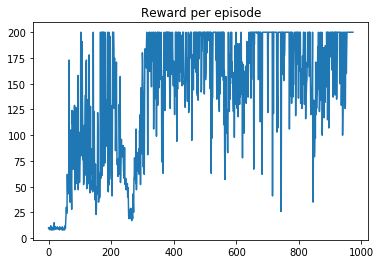

reward for the episode is : 200.0


In [16]:
main(1500)